# 모델 정의 및 학습

In [26]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

# 동일한 시드를 사용하여 동일한 변환을 이미지와 마스크에 적용
class RandomHorizontalFlip(transforms.RandomHorizontalFlip):
    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            return transforms.functional.hflip(img), transforms.functional.hflip(mask)
        return img, mask

class RandomVerticalFlip(transforms.RandomVerticalFlip):
    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            return transforms.functional.vflip(img), transforms.functional.vflip(mask)
        return img, mask

class RandomRotation(transforms.RandomRotation):
    def __call__(self, img, mask):
        angle = transforms.RandomRotation.get_params(self.degrees)
        return transforms.functional.rotate(img, angle), transforms.functional.rotate(mask, angle)

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask

class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, augmentation_factor=1, patch_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augmentation_factor = augmentation_factor
        self.patch_size = patch_size
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        assert len(self.images) == len(self.masks), "The number of images and masks must be equal"
        
        # List to hold image and mask paths
        self.image_paths = []
        self.mask_paths = []
        for img, mask in zip(self.images, self.masks):
            self.image_paths.append((os.path.join(self.image_dir, img), os.path.join(self.mask_dir, mask)))

        # Calculate number of patches per image
        self.patches_per_image = (2048 // patch_size) * (2048 // patch_size)

    def __len__(self):
        return len(self.image_paths) * self.patches_per_image * self.augmentation_factor

    def __getitem__(self, idx):
        # Determine which image and patch this index refers to
        image_index = idx // (self.patches_per_image * self.augmentation_factor)
        patch_index = (idx % (self.patches_per_image * self.augmentation_factor)) // self.augmentation_factor
        augmentation_index = idx % self.augmentation_factor
        
        img_path, mask_path = self.image_paths[image_index]

        # Open the large image and mask
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Calculate the coordinates of the patch
        patch_x = (patch_index % (2048 // self.patch_size)) * self.patch_size
        patch_y = (patch_index // (2048 // self.patch_size)) * self.patch_size

        # Crop the patch from the large image and mask
        image_patch = image.crop((patch_x, patch_y, patch_x + self.patch_size, patch_y + self.patch_size))
        mask_patch = mask.crop((patch_x, patch_y, patch_x + self.patch_size, patch_y + self.patch_size))

        if self.transform:
            image_patch, mask_patch = self.transform(image_patch, mask_patch)

        image_patch = transforms.ToTensor()(image_patch)
        mask_patch = transforms.ToTensor()(mask_patch)
        mask_patch = mask_patch.float() / 255.0

        return image_patch, mask_patch
    
# 데이터 증강 정의
augmentations = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomRotation(degrees=(0, 360))
])

# 데이터셋 로드
augmentation_factor = 3  # 증강 횟수 설정
dataset = CellSegmentationDataset(
    'C:/Users/user/Desktop/Unet/DIC_형광/Img', 
    'C:/Users/user/Desktop/Unet/DIC_형광/Mask', 
    transform=augmentations,
    augmentation_factor=augmentation_factor
)

# 학습용과 검증용 데이터셋 나누기
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 정의 (배치 크기 4 또는 8)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# 데이터셋 정보 출력
print(f"Train size: {train_size}, Validation size: {val_size}")
print(f"Train loader size: {len(train_loader)}")
print(f"Validation loader size: {len(val_loader)}")

Train size: 22, Validation size: 6
Train loader size: 6
Validation loader size: 2


# 전처리된 이미지 확인

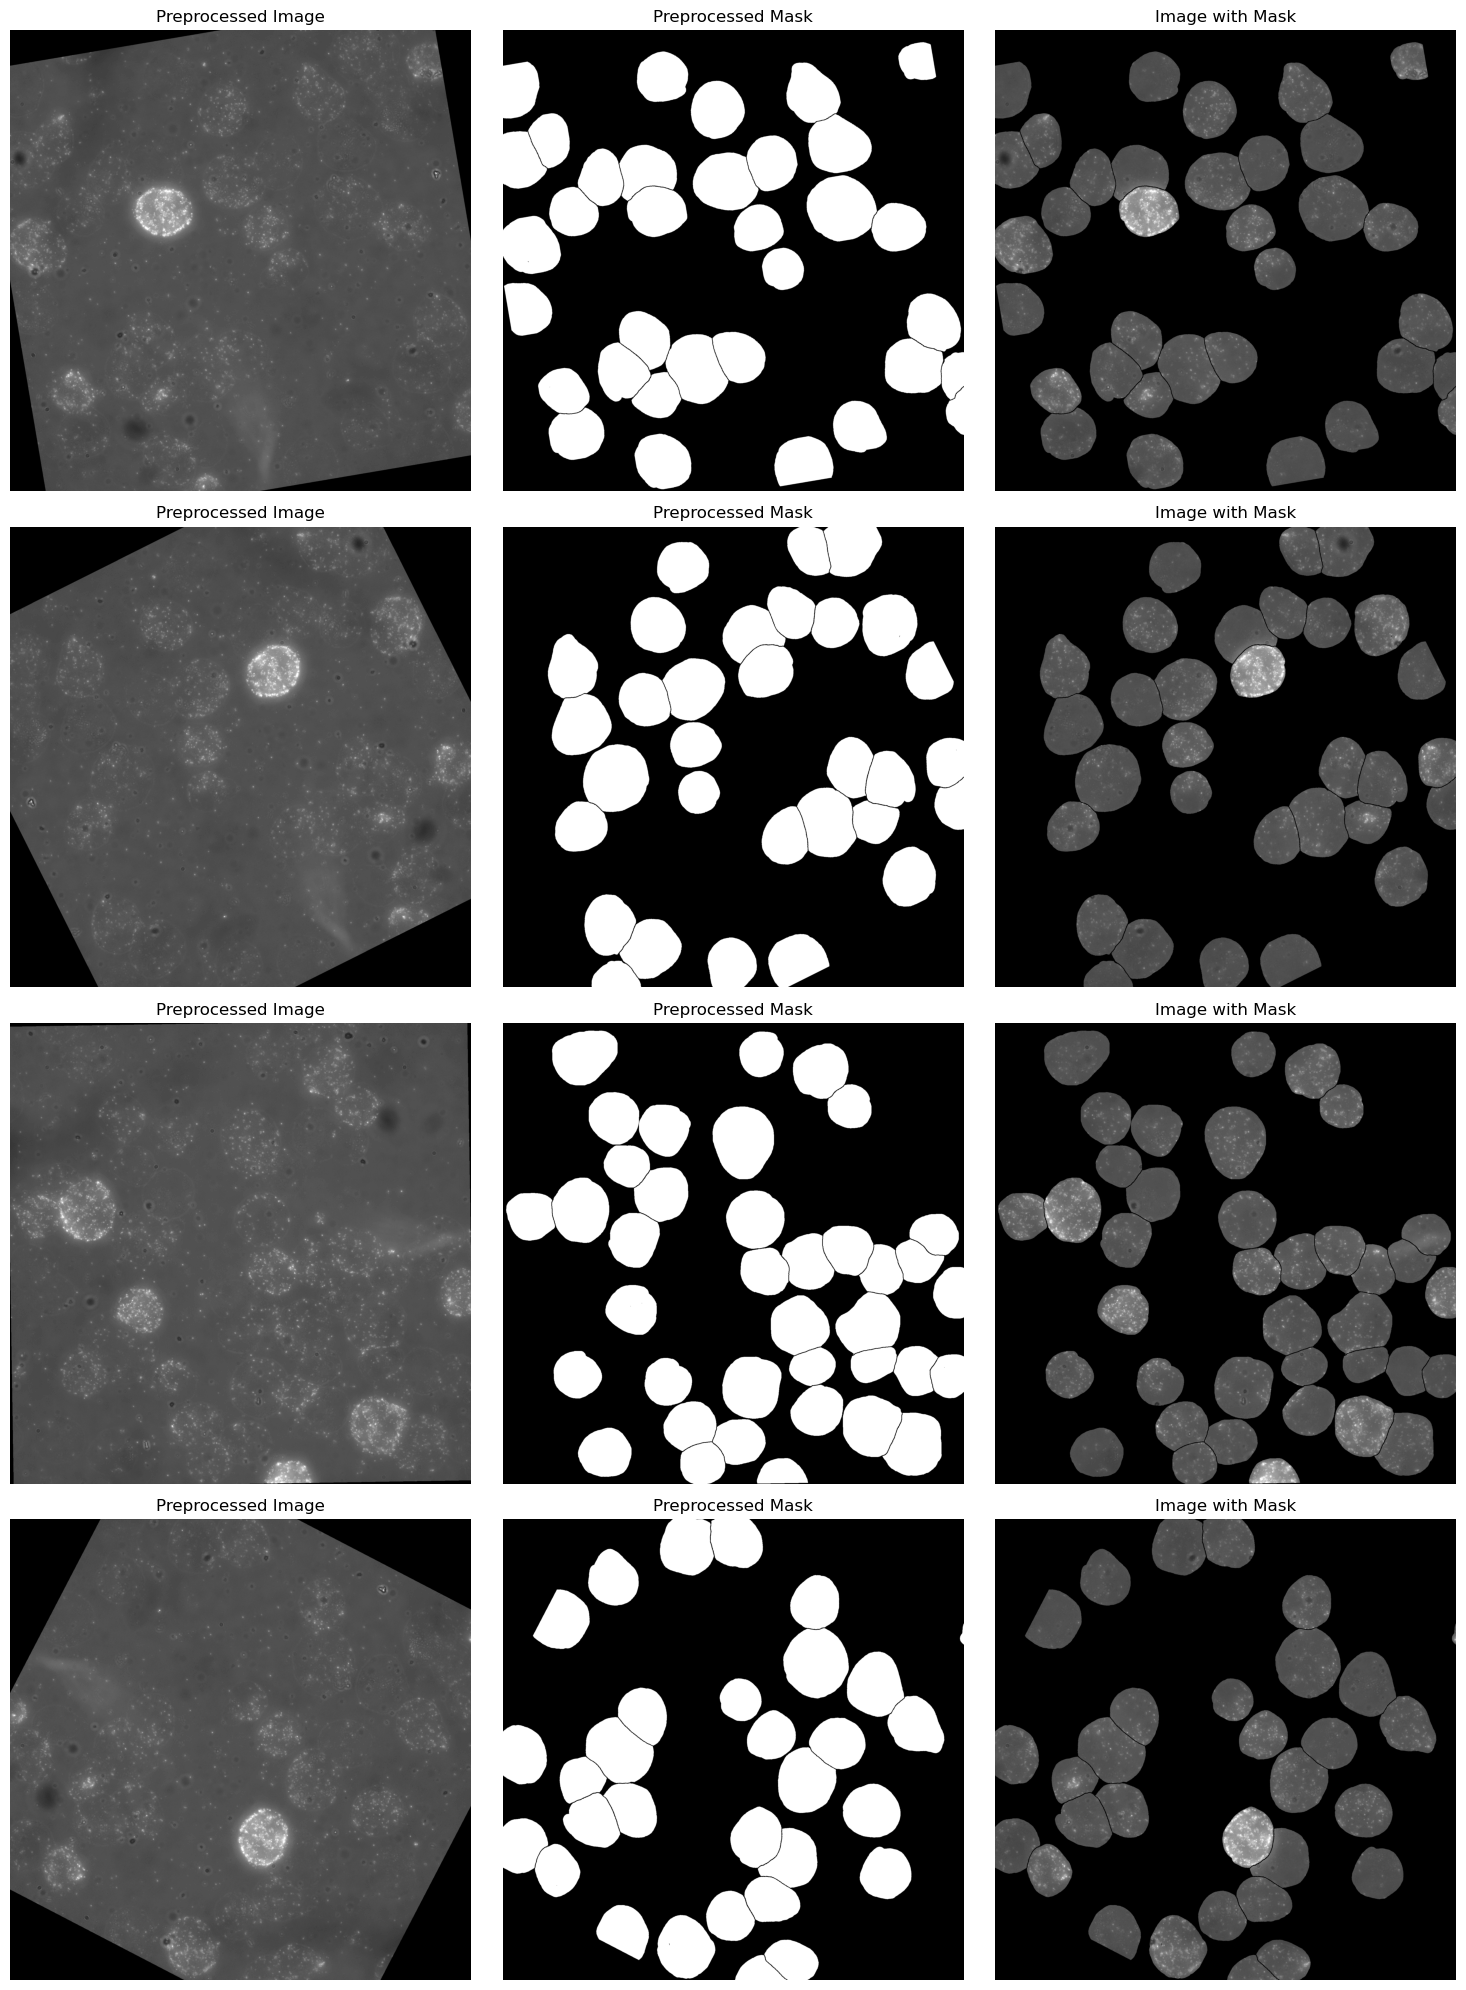

In [27]:
# 전처리된 이미지 몇 장을 시각화하는 함수
def visualize_preprocessed_images(loader, num_images=4):
    # 배치에서 이미지를 가져옵니다.
    data_iter = iter(loader)
    images, masks = next(data_iter)
    
    # 현재 배치의 이미지 수를 num_images로 제한
    num_images = min(num_images, images.size(0))
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        # 이미지를 [0, 1] 범위로 변환하여 시각화
        img = images[i].numpy().transpose((1, 2, 0)).squeeze()
        mask = masks[i].numpy().squeeze()
        
        # 이미지와 마스크를 결합하여 세포만 남기기
        img_with_mask = img * mask
        
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title('Preprocessed Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Preprocessed Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(img_with_mask, cmap='gray')
        axes[i, 2].set_title('Image with Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 전처리된 이미지 시각화
visualize_preprocessed_images(train_loader, num_images=4)

# Unet 모델 정의

In [13]:
# 모델 클래스 정의 (입력 채널 수를 1로 설정)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = up_conv_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv_block(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.functional.max_pool2d(e1, 2))
        e3 = self.encoder3(nn.functional.max_pool2d(e2, 2))
        e4 = self.encoder4(nn.functional.max_pool2d(e3, 2))

        b = self.bottleneck(nn.functional.max_pool2d(e4, 2))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        out = self.final_conv(d1)
        return out

# 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)

In [14]:
torch.cuda.is_available()

True

Epoch 1/20, Train Loss: 0.6604, Val Loss: 0.6430


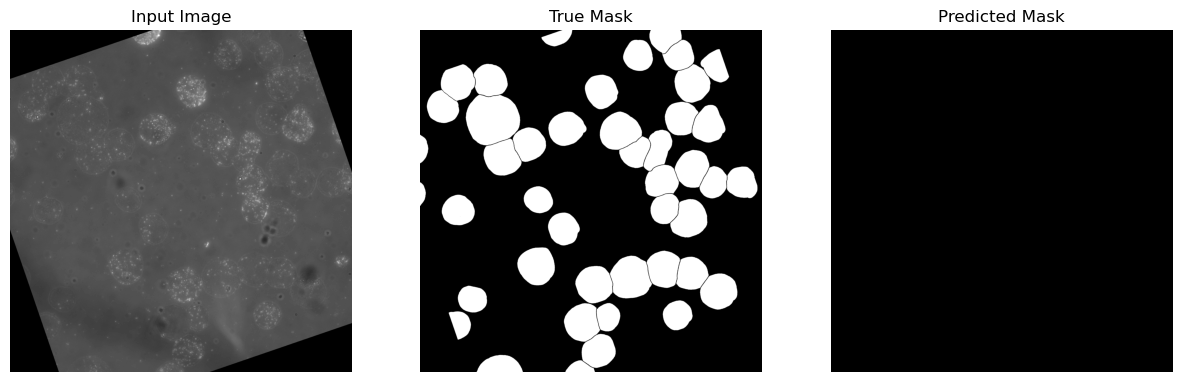

Epoch 2/20, Train Loss: 0.6278, Val Loss: 0.5969


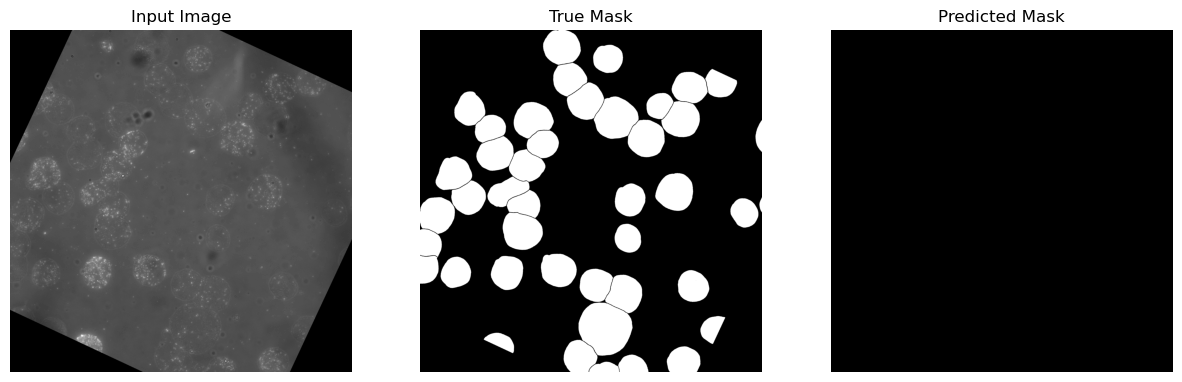

Epoch 3/20, Train Loss: 0.5638, Val Loss: 0.4774


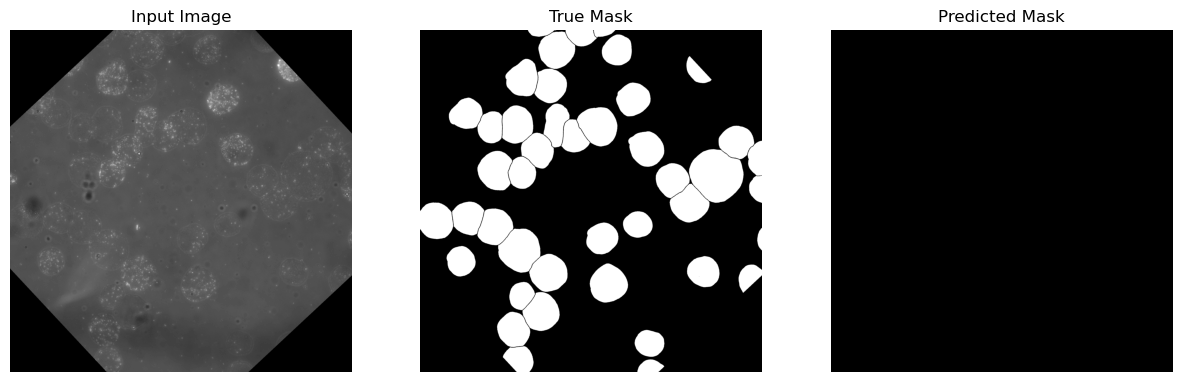

Epoch 4/20, Train Loss: 0.2642, Val Loss: 0.0367


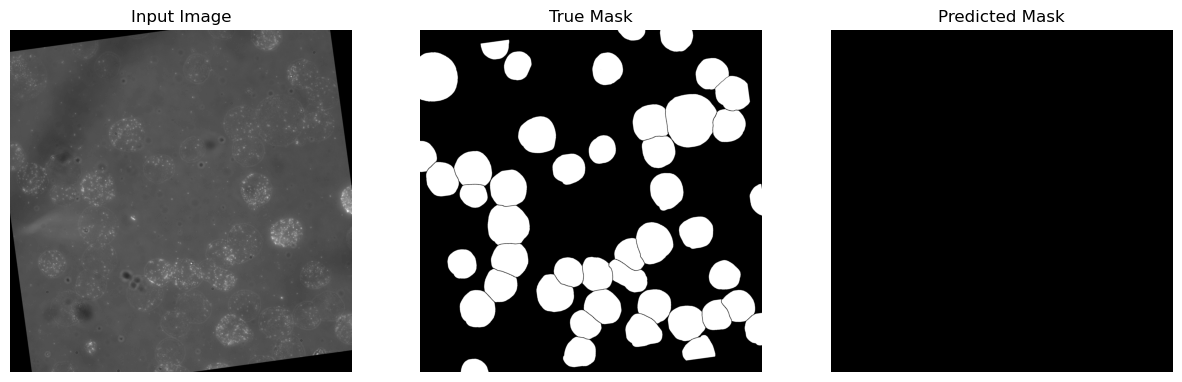

Epoch 5/20, Train Loss: 0.0850, Val Loss: 0.0339


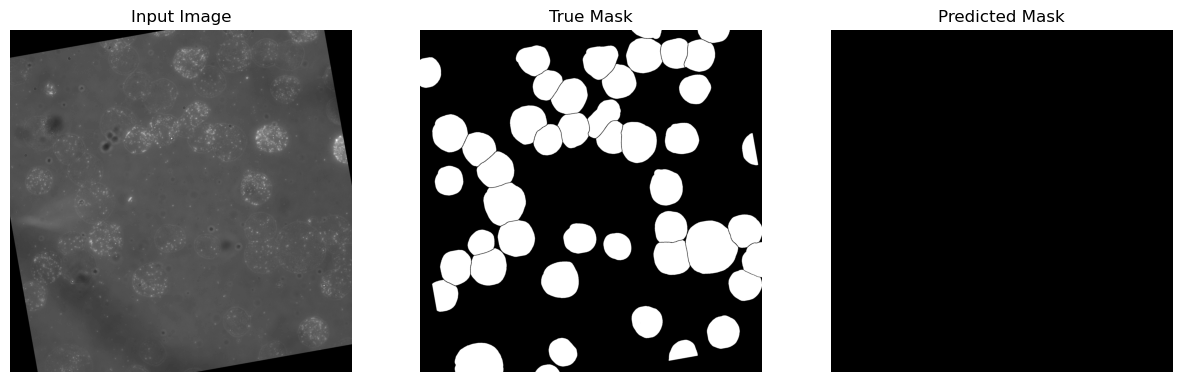

Epoch 6/20, Train Loss: 0.0191, Val Loss: 0.0197


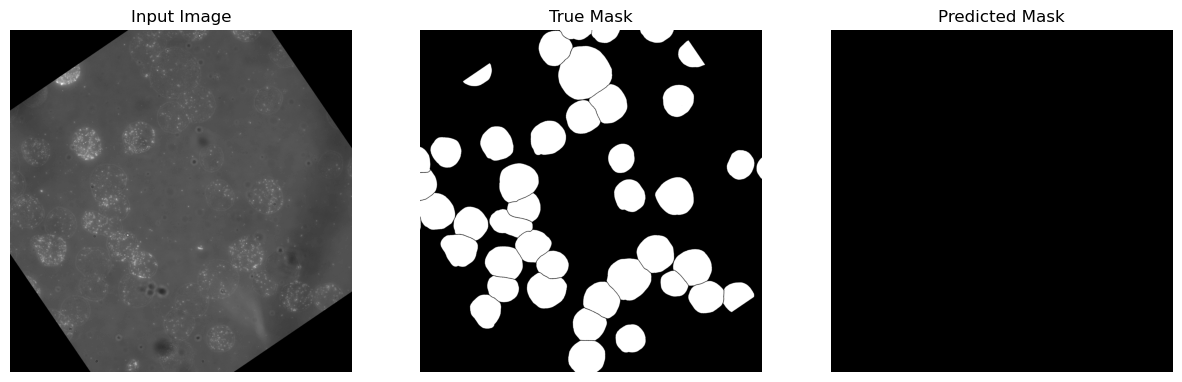

Epoch 7/20, Train Loss: 0.0196, Val Loss: 0.0106


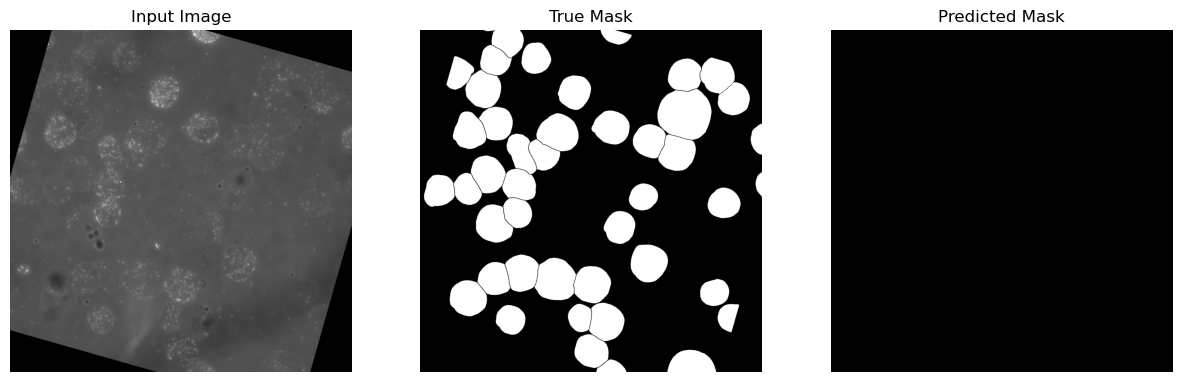

Epoch 8/20, Train Loss: 0.0118, Val Loss: 0.0129


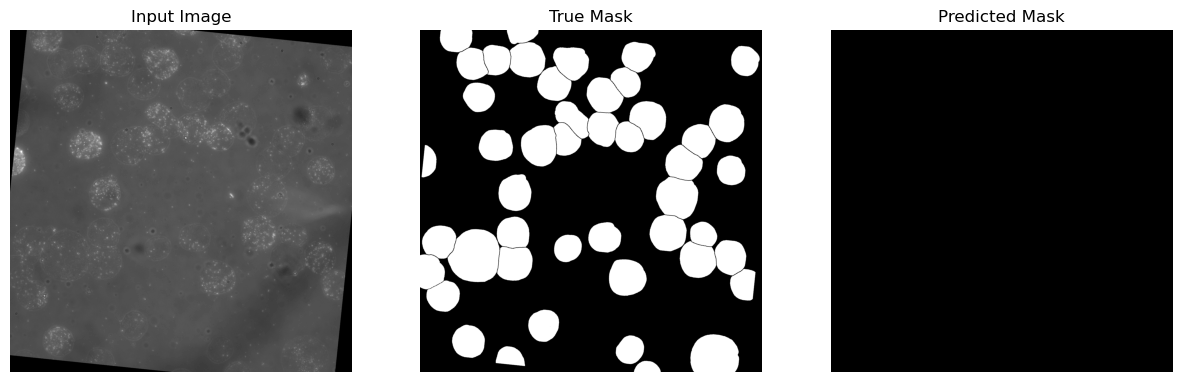

Epoch 9/20, Train Loss: 0.0132, Val Loss: 0.0107


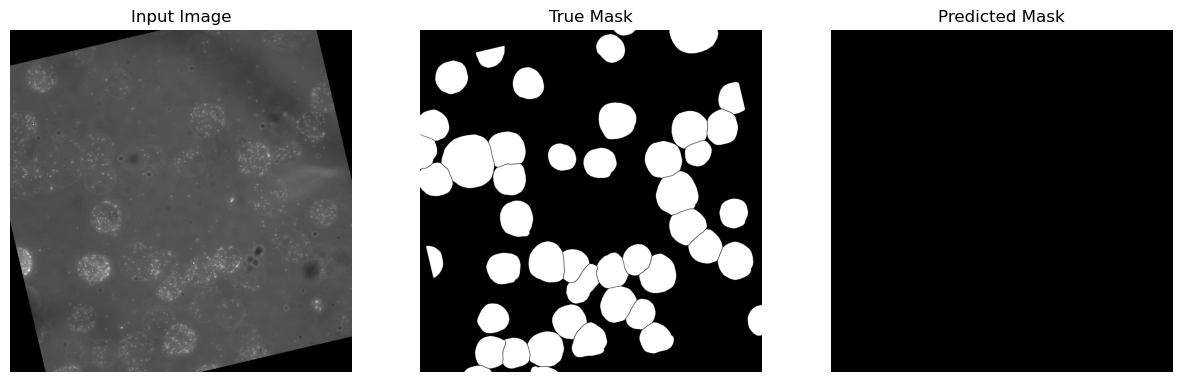

Epoch 10/20, Train Loss: 0.0107, Val Loss: 0.0105


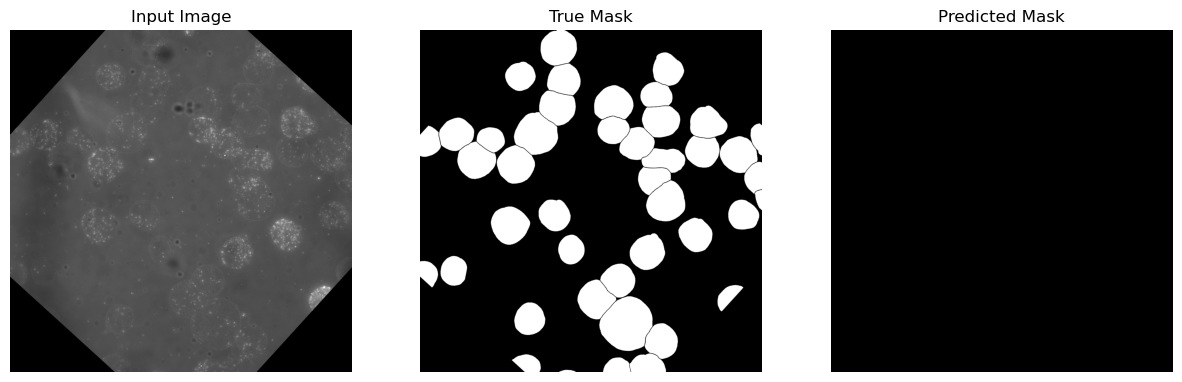

Epoch 11/20, Train Loss: 0.0106, Val Loss: 0.0102


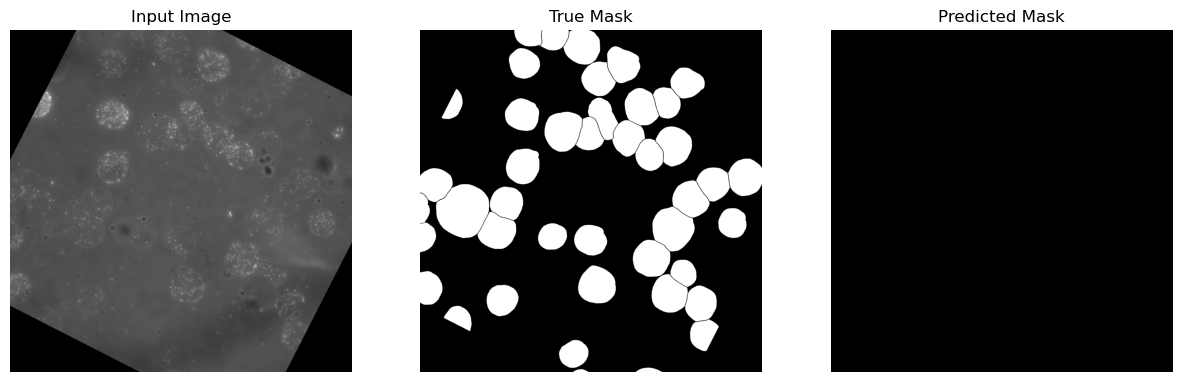

Epoch 12/20, Train Loss: 0.0105, Val Loss: 0.0100


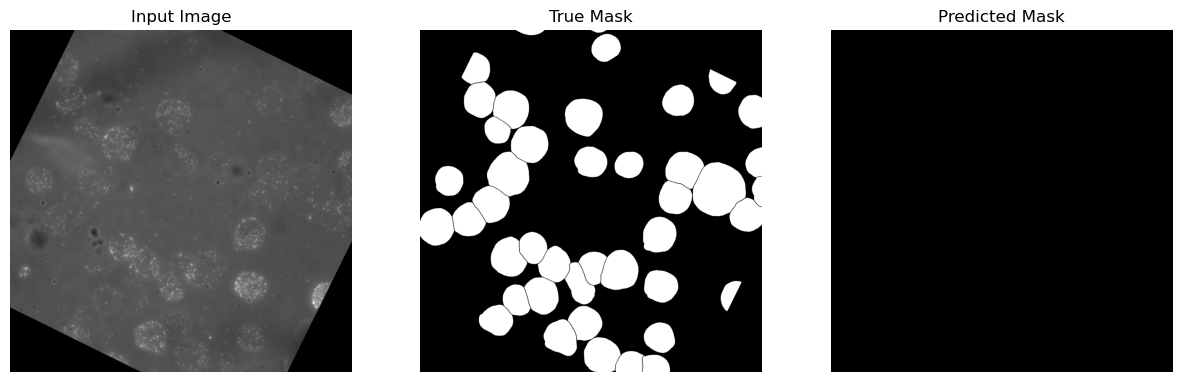

Epoch 13/20, Train Loss: 0.0103, Val Loss: 0.0100


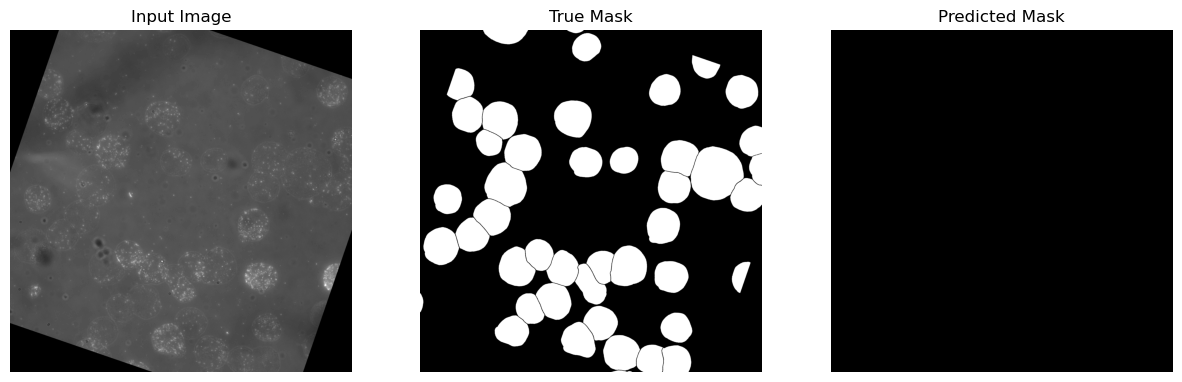

Epoch 14/20, Train Loss: 0.0103, Val Loss: 0.0099


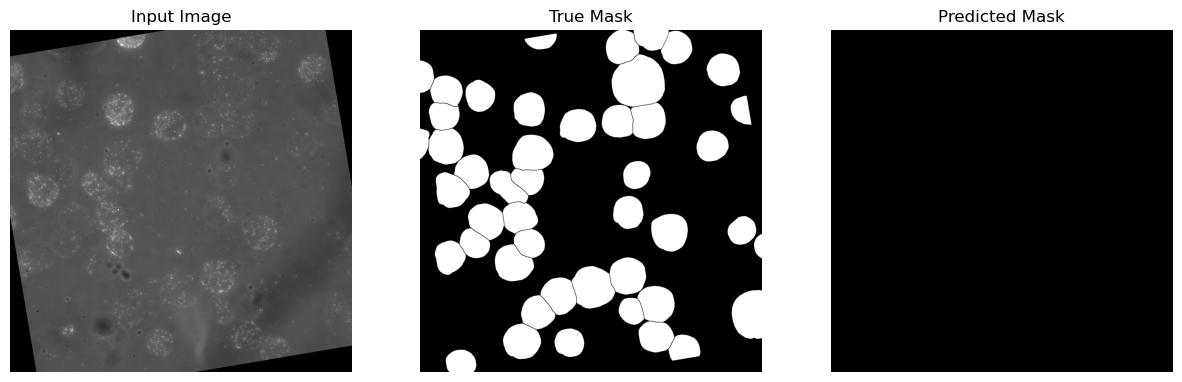

Epoch 15/20, Train Loss: 0.0102, Val Loss: 0.0099


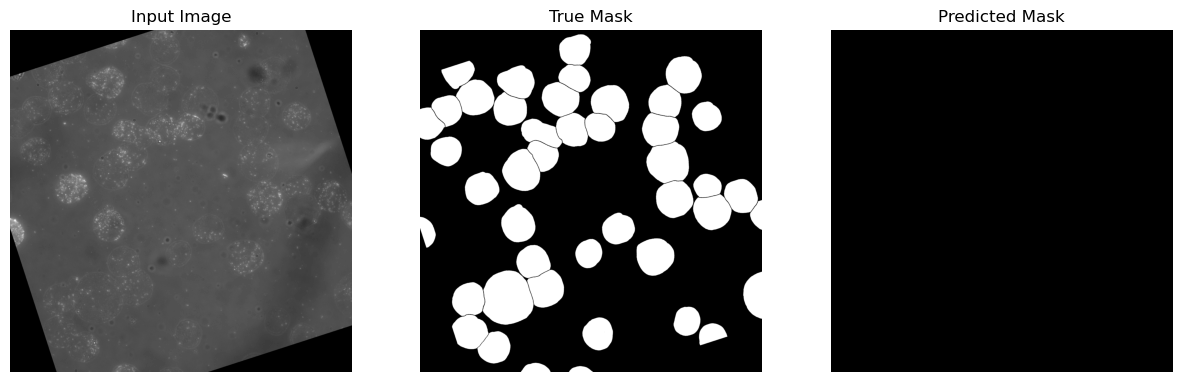

Epoch 16/20, Train Loss: 0.0103, Val Loss: 0.0098


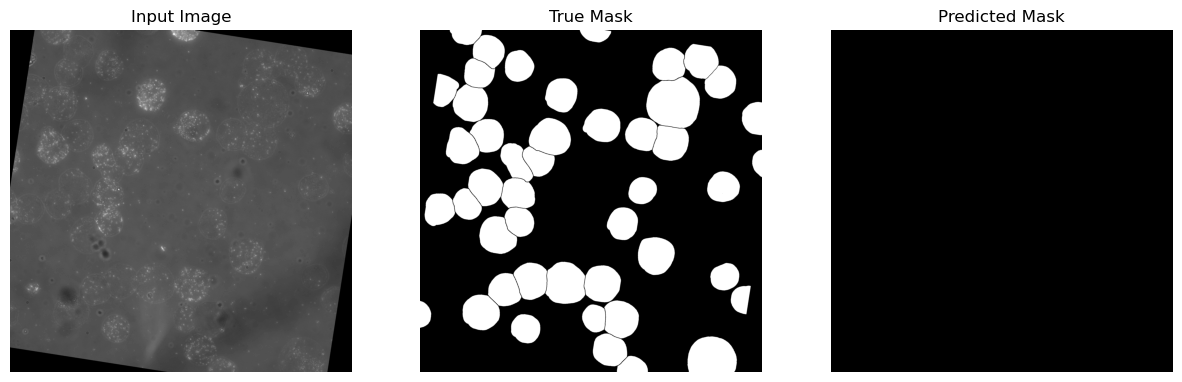

Epoch 17/20, Train Loss: 0.0103, Val Loss: 0.0098


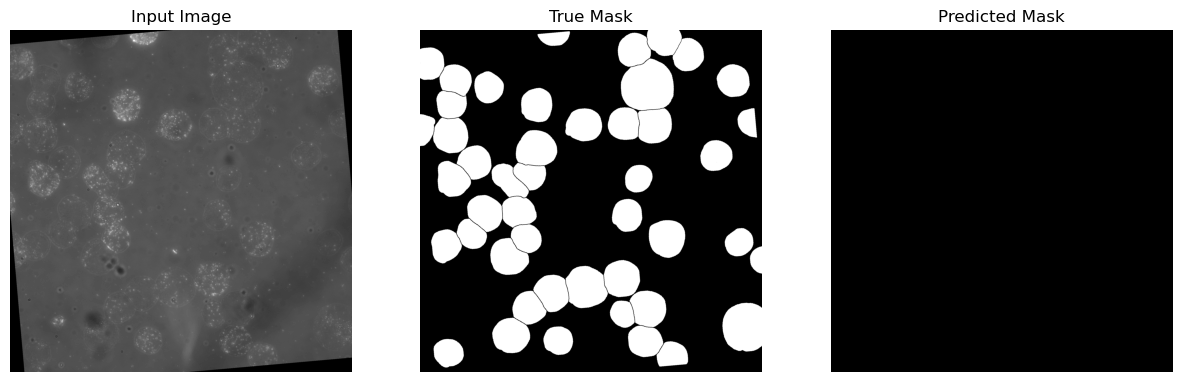

Epoch 18/20, Train Loss: 0.0102, Val Loss: 0.0099


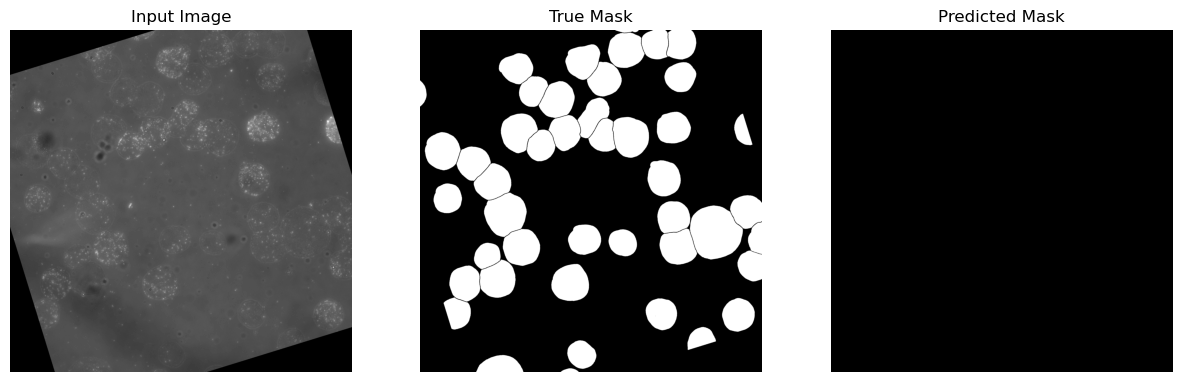

Epoch 19/20, Train Loss: 0.0101, Val Loss: 0.0096


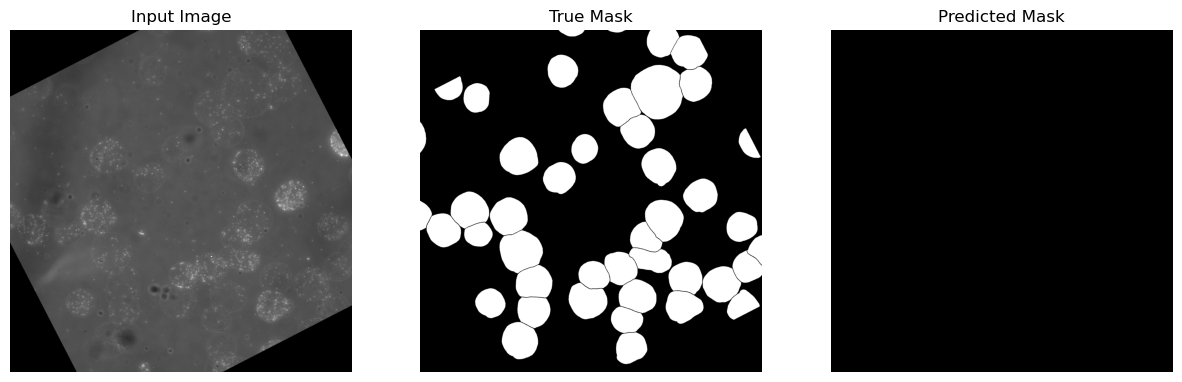

Epoch 20/20, Train Loss: 0.0102, Val Loss: 0.0097


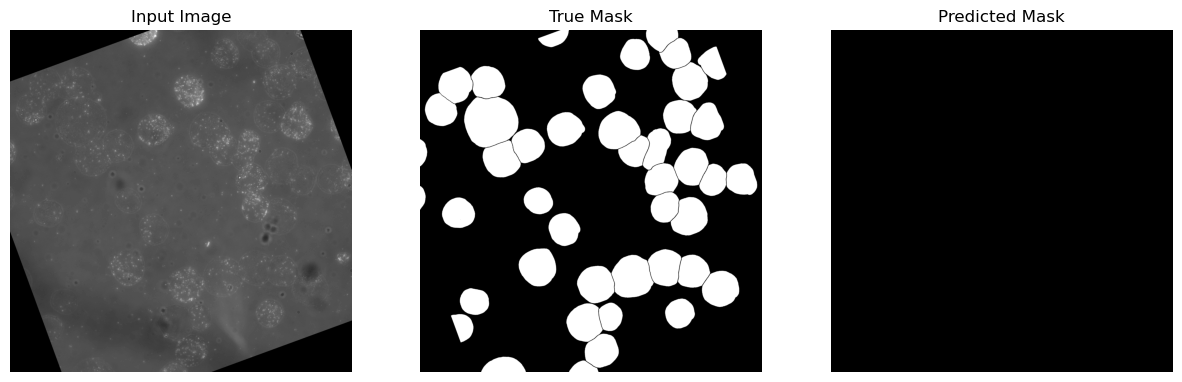

In [30]:
# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# TensorBoard 설정
writer = SummaryWriter('runs/cell_segmentation_augmentation')

# 모델 저장 함수
def save_checkpoint(state, filename="unet_checkpoint.pth"):
    torch.save(state, filename)

# 모델 불러오기 함수
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    return start_epoch

# 이전에 저장된 체크포인트가 있으면 불러오기
start_epoch = 0  # 초기 에포크 설정
if os.path.exists("unet_checkpoint.pth"):
    start_epoch = load_checkpoint("unet_checkpoint.pth")
    print(f"Checkpoint loaded, starting from epoch {start_epoch+1}")

# 학습 루프
num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # 검증 루프
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # TensorBoard에 손실 값 기록
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Val', val_loss, epoch)
    
    # 모델 저장
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, filename=f'unet_checkpoint_epoch_{epoch+1}.pth')
    
    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 예측 및 시각화
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(val_loader))
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        preds = preds.cpu().numpy()
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        axes[1].imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
        axes[1].set_title('True Mask')
        axes[1].axis('off')
        
        axes[2].imshow(preds[0].squeeze(), cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')
        
        plt.show()

writer.close()

In [ ]:
## tensorboard --logdir=C:/Users/user/Desktop/Unet/DIC_형광/runs/cell_segmentation_augmentation

## http://localhost:6006

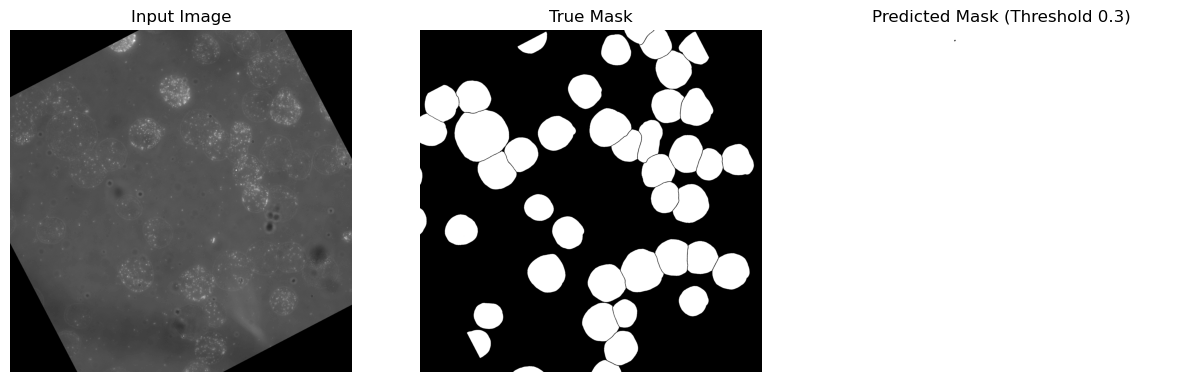

In [34]:
import matplotlib.pyplot as plt

# 모델 로드
model = UNet(in_channels=1, out_channels=1).to(device)

# 전체 체크포인트에서 모델 상태 불러오기
checkpoint = torch.load('unet_checkpoint_epoch_11.pth')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# 데이터 로더에서 하나의 배치를 가져와서 예측 시각화
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    
    # 임계값 조정
    threshold = 0.0001  # 임계값을 낮게 설정
    binary_preds = preds > threshold
    binary_preds = binary_preds.cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
    axes[1].set_title('True Mask')
    axes[1].axis('off')
    
    axes[2].imshow(binary_preds[0].squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask (Threshold 0.3)')
    axes[2].axis('off')
    
    plt.show()


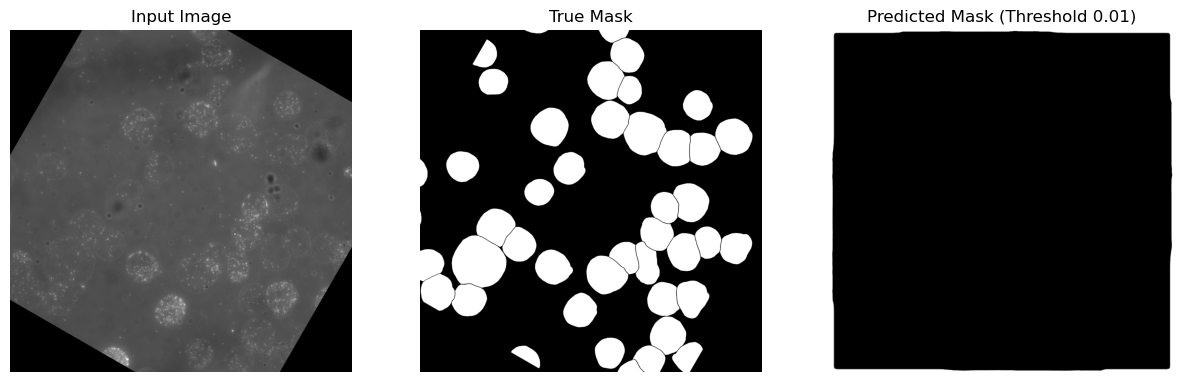

In [36]:
# 데이터 로더에서 하나의 배치를 가져와서 예측 시각화
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    
    # 임계값 조정
    threshold = 0.005  # 임계값을 낮게 설정
    binary_preds = preds > threshold
    binary_preds = binary_preds.cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
    axes[1].set_title('True Mask')
    axes[1].axis('off')
    
    axes[2].imshow(binary_preds[0].squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask (Threshold 0.01)')
    axes[2].axis('off')
    
    plt.show()


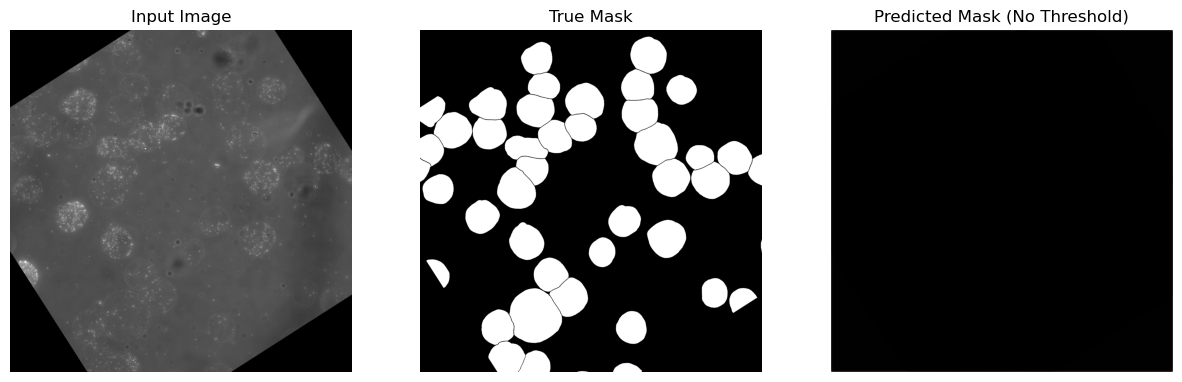

In [38]:
import matplotlib.pyplot as plt

# 모델 로드
model = UNet(in_channels=1, out_channels=1).to(device)

# 전체 체크포인트에서 모델 상태 불러오기
checkpoint = torch.load('unet_checkpoint_epoch_20.pth')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# 데이터 로더에서 하나의 배치를 가져와서 예측 시각화
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs).cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
    axes[1].set_title('True Mask')
    axes[1].axis('off')
    
    axes[2].imshow(preds[0].squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask (No Threshold)')
    axes[2].axis('off')
    
    plt.show()

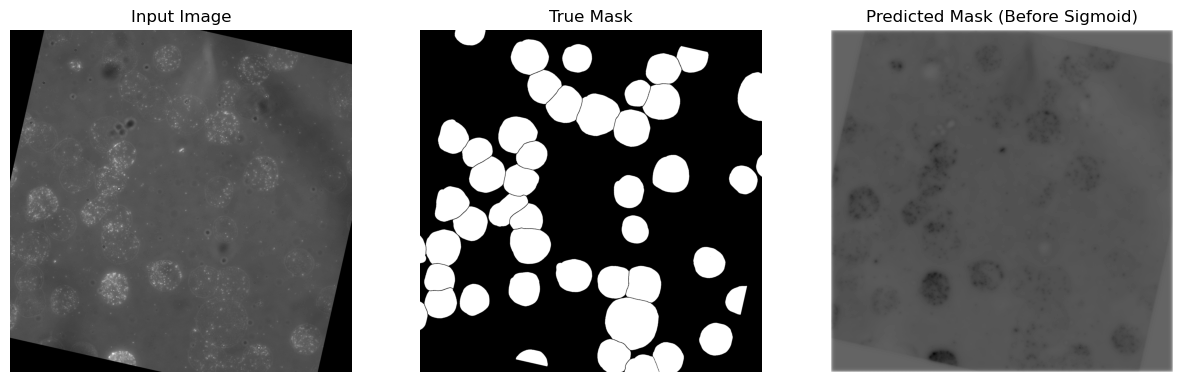

In [39]:
import matplotlib.pyplot as plt

# 모델 로드
model = UNet(in_channels=1, out_channels=1).to(device)

# 전체 체크포인트에서 모델 상태 불러오기
checkpoint = torch.load('unet_checkpoint_epoch_20.pth')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# 데이터 로더에서 하나의 배치를 가져와서 예측 시각화
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    preds = outputs.cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
    axes[1].set_title('True Mask')
    axes[1].axis('off')
    
    axes[2].imshow(preds[0].squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask (Before Sigmoid)')
    axes[2].axis('off')
    
    plt.show()
